<a href="https://colab.research.google.com/github/nts-e/-transfer_learning_vgg19_xception/blob/main/TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning - Chest X-Ray Images (Pneumonia)**

* Based on a Kaggle [dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)
* Using VGG19 and Xception for binary classification



# Prepare Transfer Learning Model

## Initializations

In [ ]:

RANDOM_STATE                  = 1

USE_GOOGLE_DRIVE_FOR_FILES    = True
DATA_FOLDER_PATH              = ""

if USE_GOOGLE_DRIVE_FOR_FILES:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing           import image
from tensorflow.keras.optimizers              import Adam
from tensorflow.keras.metrics                 import Precision, Recall
from keras                                    import Input, Sequential
from keras.applications.vgg19                 import VGG19, preprocess_input, decode_predictions
from tensorflow.keras.applications.xception   import Xception
from keras.callbacks                          import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from keras.layers                             import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Activation
from keras.models                             import Model, load_model
from sklearn.preprocessing                    import label_binarize
from sklearn.model_selection                  import train_test_split
from tqdm                                     import tqdm

import pickle
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import math


## Create dataframe

**The 'Create dataframe' section can be skipped if done before. Just load chest_xray.csv from storage**

In [ ]:
# if exists
df = pd.read_csv(f"{DATA_FOLDER_PATH}/chest_xray.csv")

**Skip the rest of this section if you loaded from CSV**

Load images names and labels from the files folder

In [ ]:
name = []
label= []
original_fold=[]
path=[]

for fold in ['train', 'test']:
  for label_type in ['NORMAL', 'PNEUMONIA']:
    current_path = f"{DATA_FOLDER_PATH}/{fold}/{label_type}"
    ld = os.listdir(current_path)
    jpegs_names = [file_name for file_name in ld if file_name[-4:]=='jpeg']
    name.extend([file_name for file_name in ld if file_name[-4:]=='jpeg'])
    label.extend([1 if label_type=='PNEUMONIA' else 0] * len(jpegs_names))
    original_fold.extend([fold] * len(jpegs_names))
    path.extend([f"{current_path}/{n}" for n in jpegs_names])

df = pd.DataFrame({'name': name, 'label': label, 'original_fold': original_fold, 'path': path})

In [ ]:
df['label'].value_counts()

1    4273
0    1583
Name: label, dtype: int64

In [ ]:
#shuffle
df = df.sample(frac=1, random_state=RANDOM_STATE).reset_index()
df.head()

,level_0,Unnamed: 0,index,name,label,original_fold,path,image_x,image_y
0,222,222,1676,person1180_virus_2011.jpeg,1,train,/content/drive/My Drive/Data Science/Naya/Proj...,592,936
1,2326,2326,481,IM-0624-0001-0002.jpeg,0,train,/content/drive/My Drive/Data Science/Naya/Proj...,1334,1690
2,2162,2162,4585,person653_bacteria_2545.jpeg,1,train,/content/drive/My Drive/Data Science/Naya/Proj...,784,1136
3,2363,2363,5440,NORMAL2-IM-0139-0001.jpeg,0,test,/content/drive/My Drive/Data Science/Naya/Proj...,1375,2014
4,5651,5651,591,IM-0656-0001.jpeg,0,train,/content/drive/My Drive/Data Science/Naya/Proj...,1395,1504


Example of an image

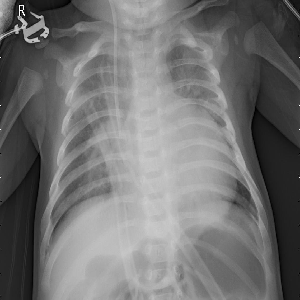

In [ ]:
img = image.load_img(df['path'][2], target_size=(300,300))
img

Variable image sizes 

In [ ]:
arr = image.img_to_array(image.load_img(df['path'][1]))[:,:,1]
print(arr.shape)

arr = image.img_to_array(image.load_img(df['path'][2]))[:,:,1]
print(arr.shape)

(616, 944)
(856, 1312)


**Skip this - can be loaded from pickle later**

In [ ]:
#check all
from tqdm import tqdm

image_x = []
image_y = []
file_paths = df['path'].to_list()
for i in tqdm(range(len(file_paths))):
  arr = image.img_to_array(image.load_img(file_paths[i]))[:,:,1]
  image_x.append(arr.shape[0])
  image_y.append(arr.shape[1])

df['image_x'] = image_x
df['image_y'] = image_y

In [ ]:
df.to_csv(f"{DATA_FOLDER_PATH}/chest_xray.csv")

In [ ]:
print(df['image_x'].min(),df['image_x'].max(), df['image_x'].mean())
print(df['image_y'].min(),df['image_y'].max(), df['image_y'].mean())

127 2713 970.6890368852459
384 2916 1327.880806010929


In [ ]:
# Determine the input size
input_size = (200, 200)

## Load images

**Note:** load using the next section and skip the following loading sections.

In [ ]:
# load X
with open(f"{DATA_FOLDER_PATH}/X_200_200_raw.pkl", 'rb') as f:
    X = pickle.load(f)

**skip if loaded from pickle**

In [ ]:

print("Loading images to variable X...")
l_img = []
file_paths = list(df['path'].values)

for i in tqdm(range(len(file_paths))):
  img = cv2.resize(cv2.imread(file_paths[i], cv2.IMREAD_GRAYSCALE), input_size)
  l_img.append(img)
  
X = np.array(l_img)

Loading images to variable X...


100%|██████████| 5856/5856 [21:39<00:00,  4.51it/s]


## Split

In [ ]:
# expand from grayscale to 3 channels
X = np.expand_dims(X, -1)
X = X.repeat(3, axis=-1)
X.shape

(5856, 200, 200, 3)

In [ ]:
y = np.array(df['label'])

# Split: 70% train, 10% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.12, random_state=RANDOM_STATE, stratify=y_temp)

print(f'Train: {X_train.shape}', f'Validation: {X_valid.shape}', f'Test: {X_test.shape}', sep="\n")

Train: (4121, 200, 200, 3)
Validation: (563, 200, 200, 3)
Test: (1172, 200, 200, 3)


# Transfer learning model - VGG 19

VGG 19 dedicated scaling

In [ ]:

# subtracting the mean RGB value, computed on the training set, from each pixel
X_test = preprocess_input(X_test)
X_valid = preprocess_input(X_valid)
X_train = preprocess_input(X_train)

In [ ]:
run_number = 1

num_epochs = 30
learning_rate = 1 * 1e-3
early_stopping_patience = 4
early_stopping_min_delta = 0.003
batch_size = 32

optimizer = Adam(learning_rate=learning_rate) 

model_file_prefix = f'{DATA_FOLDER_PATH}/{run_number}' 

# callback 1: early stopping (for short runs)
es = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, min_delta=early_stopping_min_delta, verbose=1)

# callback 2: model checkpoint
cp = ModelCheckpoint(filepath=model_file_prefix + '_best_model.h5', mode='max', monitor='val_accuracy', save_best_only=True, verbose=1)

# callback 3: reduce learning rate on plateau. all values are default except verbose.
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.1,
                              patience=10,
                              verbose=1,
                              mode="auto",
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0
                              )

# For fitting few times in a sequence, use validation_data = (X_valid, y_valid), otherwise use validation_split. Here I use it like that for control and debugging
validation_data = (X_valid, y_valid)

input_shape= [input_size[0], input_size[1], 3]

# include_top=False --> get the outputs of the convolution layers, before the FC layers
base_model = VGG19(input_shape=input_shape, weights='imagenet', include_top=False)

base_model.trainable = False

inputs = Input(shape=input_shape)

o = base_model(inputs, training=False)
o = GlobalAveragePooling2D()(o)
o = Dense(1024)(o)
o = BatchNormalization()(o)
o = Activation('relu')(o)
o = Dropout(rate=0.3, seed=RANDOM_STATE)(o)
  
predictions = Dense(1, activation='sigmoid')(o)
model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer=optimizer,  loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 6, 6, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 1024)              0     

In [ ]:
history_test={'test_loss': [], 'test_accuracy': [], 'test_precision': [], 'test_recall': []}

class EvaluateEpochEnd(Callback):
    def __init__(self, test_data):
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        #super().on_epoch_end(epoch, logs)
        x, y = self.test_data
        scores = self.model.evaluate(x, y, verbose=False)
        history_test['test_loss'].append(scores[0])
        history_test['test_accuracy'].append(scores[1])
        history_test['test_precision'].append(scores[2])
        history_test['test_recall'].append(scores[3])
        print('\nTesting loss: {}, accuracy: {}, precision: {}, recall: {}\n'.format(scores[0], scores[1], scores[2], scores[3]))

class EpochModelCheckpoint(ModelCheckpoint):

    def __init__(self,
                 filepath,
                 frequency=1,
                 monitor='val_loss',
                 verbose=0,
                 save_best_only=False,
                 save_weights_only=False,
                 mode='auto',
                 options=None,
                 **kwargs):
        super(EpochModelCheckpoint, self).__init__(filepath, monitor, verbose, save_best_only, save_weights_only,
                                                   mode, "epoch", options)
        self.epochs_since_last_save = 0
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        self.epochs_since_last_save += 1
        # pylint: disable=protected-access
        if self.epochs_since_last_save % self.frequency == 0:
            self._save_model(epoch=epoch, batch=None, logs=logs)

    def on_train_batch_end(self, batch, logs=None):
        pass

In [ ]:
# I used a callback that saves the model every 10 epochs. I calculate the test loss and accuracy on these checkpoints after the run is finished.
history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_data=validation_data, callbacks=[cp, reduce_lr, EpochModelCheckpoint(model_file_prefix + '_epoch_{epoch:03d}.h5', frequency=10)])

# print all the run history, that can be used later on for the graphs
print("RUN HISTORY:\n")
print(history.history.keys())
print(history.history.values())

Epoch 1/30
129/129 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9393 - precision: 0.9590 - recall: 0.9578
Epoch 1: val_accuracy improved from -inf to 0.90941, saving model to /content/drive/My Drive/Data Science/Naya/Projects/5 - Final/Data/1_best_model.h5
129/129 [==============================] - 33s 217ms/step - loss: 0.1628 - accuracy: 0.9393 - precision: 0.9590 - recall: 0.9578 - val_loss: 0.2761 - val_accuracy: 0.9094 - val_precision: 0.9891 - val_recall: 0.8856 - lr: 0.0010
Epoch 2/30
129/129 [==============================] - ETA: 0s - loss: 0.0819 - accuracy: 0.9704 - precision: 0.9807 - recall: 0.9787
Epoch 2: val_accuracy improved from 0.90941 to 0.95204, saving model to /content/drive/My Drive/Data Science/Naya/Projects/5 - Final/Data/1_best_model.h5
129/129 [==============================] - 24s 186ms/step - loss: 0.0819 - accuracy: 0.9704 - precision: 0.9807 - recall: 0.9787 - val_loss: 0.1399 - val_accuracy: 0.9520 - val_precision: 0.9848 - val

In [ ]:
# After the run the saved models are loaded to predict the test accuracy and loss every 10th epoch 
for i in range(10, num_epochs+1, 10):
  final_model = load_model(f'{model_file_prefix}_epoch_{i:03d}.h5')
  scores = final_model.evaluate(X_test,y_test)
  history_test['test_loss'].append(scores[0])
  history_test['test_accuracy'].append(scores[1])
  history_test['test_precision'].append(scores[2])
  history_test['test_recall'].append(scores[3])

37/37 [==============================] - 6s 150ms/step - loss: 0.1314 - accuracy: 0.9642 - precision: 0.9646 - recall: 0.9871


In [ ]:
plot_data = {}

plot_data_keys = list(history.history.keys())
plot_data_values = list(history.history.values())

for i in range(len(plot_data_keys)):
  plot_data[plot_data_keys[i]] = plot_data_values[i]
  
# best model predictions
final_model = load_model(model_file_prefix + '_best_model.h5')
scores = final_model.evaluate(X_test,y_test)
print(scores)

best_epic_number = 23
# will be used in the plot !!!

In [ ]:
def f1(precision, recall):
  return 2 / ((1/precision) + (1/recall))

# f1 score of best model:
f1(0.9635, 0.9871)

0.9751572336716908

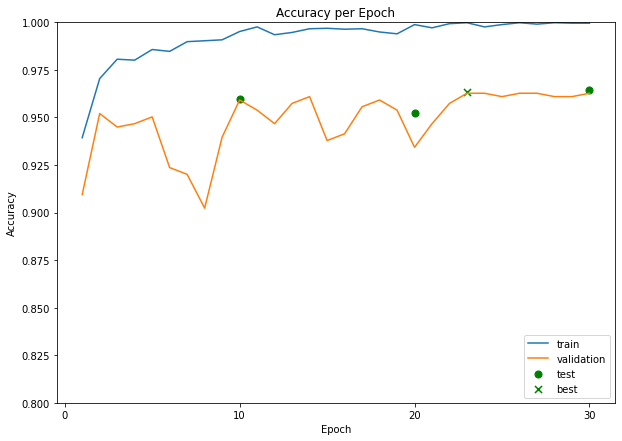

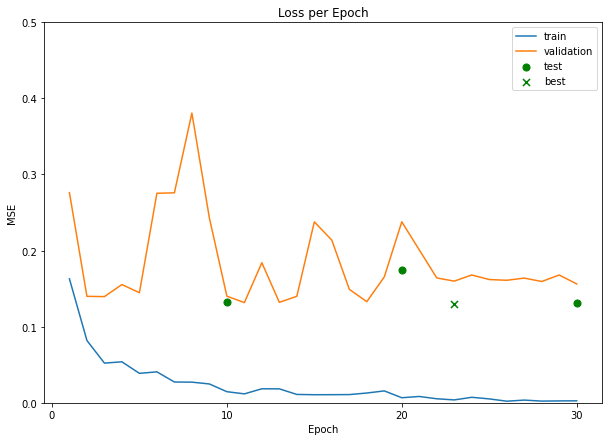

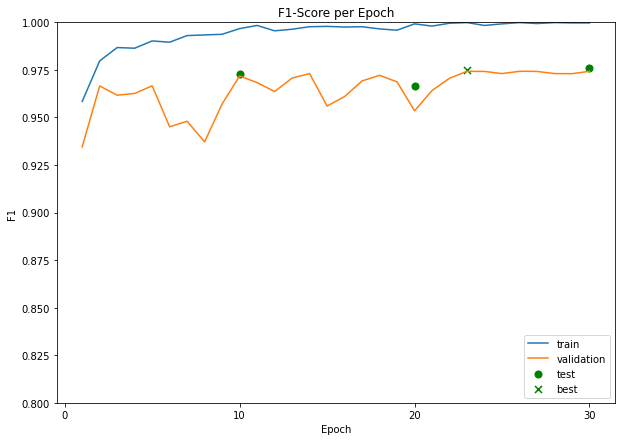

In [ ]:
num_of_x_values = len(plot_data_values[0])

# summarize history for accuracy
fig = plt.figure(figsize = (10, 7))
plt.plot(np.arange(1,num_of_x_values+1), plot_data['accuracy'])
plt.plot(np.arange(1,num_of_x_values+1), plot_data['val_accuracy'])
plt.scatter(np.arange(10,num_of_x_values+1, 10), history_test['test_accuracy'], s=50, color='green')
plt.scatter([best_epic_number], scores[1], s=50, color='green', marker='x')

plt.title('Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,num_of_x_values+1,10))

plt.legend(['train', 'validation', 'test', 'best'], loc='lower right')
plt.ylim([0.8,1])

plt.show()

# summarize history for loss
fig = plt.figure(figsize = (10, 7))
plt.plot(np.arange(1,num_of_x_values+1), plot_data['loss'])
plt.plot(np.arange(1,num_of_x_values+1), plot_data['val_loss'])
plt.scatter(np.arange(10,num_of_x_values+1, 10), history_test['test_loss'], s=50, color='green')
plt.scatter([best_epic_number], scores[0], s=50, color='green', marker='x')

plt.title('Loss per Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
#plt.xticks(np.arange(1,len(history.epoch)+1))
plt.xticks(np.arange(0,num_of_x_values+1,10))
plt.legend(['train', 'validation', 'test', 'best'], loc='upper right')
plt.ylim([0,0.5])

plt.show()


# f1
plot_data['f1'] = f1(np.array(plot_data['precision']),np.array(plot_data['recall']))
plot_data['val_f1'] = f1(np.array(plot_data['val_precision']),np.array(plot_data['val_recall']))
plot_data['test_f1'] = f1(np.array(history_test['test_precision']),np.array(history_test['test_recall']))

fig = plt.figure(figsize = (10, 7))
plt.plot(np.arange(1,num_of_x_values+1), plot_data['f1'])
plt.plot(np.arange(1,num_of_x_values+1), plot_data['val_f1'])
plt.scatter(np.arange(10,num_of_x_values+1, 10), plot_data['test_f1'], s=50, color='green')
plt.scatter([best_epic_number], f1(scores[2], scores[3]), s=50, color='green', marker='x')

plt.title('F1-Score per Epoch')
plt.ylabel('F1')
plt.xlabel('Epoch')
#plt.xticks(np.arange(1,len(history.epoch)+1))
plt.xticks(np.arange(0,num_of_x_values+1,10))
plt.legend(['train', 'validation', 'test', 'best'], loc='lower right')
plt.ylim([0.8,1.0])

plt.show()


Accuracy is high and we choose not to train the VGG layers. 

Therefore it is actually Fine Tuning and not Transfer Learning.

# Transfer Learning Model - Xception

## Reload X, split and scale

In [ ]:
with open(f"{DATA_FOLDER_PATH}/X_200_200_raw.pkl", 'rb') as f:
    X = pickle.load(f)

In [ ]:
# expand from grayscale to 3 channels
X = np.expand_dims(X, -1)
X = X.repeat(3, axis=-1)
X.shape

(5856, 200, 200, 3)

In [ ]:
#y = np.array(df['label'])

# Split: 70% train, 10% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.12, random_state=RANDOM_STATE, stratify=y_temp)

print(f'Train: {X_train.shape}', f'Validation: {X_valid.shape}', f'Test: {X_test.shape}', sep="\n")

Train: (4121, 200, 200, 3)
Validation: (563, 200, 200, 3)
Test: (1172, 200, 200, 3)


In [ ]:
# Xception weights requires that input be scaled from (0, 255) to a range of (-1., +1.)
X_test = X_test / 127.5 - 1.
X_valid = X_valid / 127.5 - 1.
X_train = X_train / 127.5 - 1.

In [ ]:
run_number = 2

num_epochs = 30
learning_rate = 1 * 1e-3
early_stopping_patience = 4
early_stopping_min_delta = 0.003
batch_size = 32

optimizer = Adam(learning_rate=learning_rate) 

model_file_prefix = f'{DATA_FOLDER_PATH}/{run_number}' 

# callback 1: early stopping (for short runs)
es = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, min_delta=early_stopping_min_delta, verbose=1)

# callback 2: model checkpoint
cp = ModelCheckpoint(filepath=model_file_prefix + '_best_model.h5', mode='max', monitor='val_accuracy', save_best_only=True, verbose=1)

# callback 3: reduce learning rate on plateau. all values are default except verbose.
reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                              factor=0.1,
                              patience=10,
                              verbose=1,
                              mode="auto",
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0
                              )

# For fitting few times in a sequence, use validation_data = (X_valid, y_valid), otherwise use validation_split. Here I use it like that for control and debugging
validation_data = (X_valid, y_valid)

input_shape= [input_size[0], input_size[1], 3]

# include_top=False --> get the outputs of the convolution layers, before the FC layers
base_model = Xception(input_shape=input_shape, weights='imagenet', include_top=False)

base_model.trainable = False

inputs = Input(shape=input_shape)

o = base_model(inputs, training=False)
o = GlobalAveragePooling2D()(o)
o = Dense(512)(o)
o = BatchNormalization()(o)
o = Activation('relu')(o)
o = Dropout(rate=0.3, seed=RANDOM_STATE)(o)

predictions = Dense(1, activation='sigmoid')(o)
model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer=optimizer,  loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])

83683744/83683744 [==============================] - 4s 0us/step


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 batch_normalization_5 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 512)               0   

In [ ]:
# I used a callback that saves the model every 10 epochs. I calculate the test loss and accuracy on these checkpoints after the run is finished.
history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, validation_data=validation_data, callbacks=[cp, reduce_lr, EpochModelCheckpoint(model_file_prefix + '_epoch_{epoch:03d}.h5', frequency=10)])

# print all the run history, that can be used later on for the graphs
print("RUN HISTORY:\n")
print(history.history.keys())
print(history.history.values())

Epoch 1/30
129/129 [==============================] - ETA: 0s - loss: 0.2031 - accuracy: 0.9257 - precision_1: 0.9543 - recall_1: 0.9435
Epoch 1: val_accuracy improved from -inf to 0.92185, saving model to /content/drive/My Drive/Data Science/Naya/Projects/5 - Final/Data/2_best_model.h5
129/129 [==============================] - 25s 166ms/step - loss: 0.2031 - accuracy: 0.9257 - precision_1: 0.9543 - recall_1: 0.9435 - val_loss: 0.1873 - val_accuracy: 0.9218 - val_precision_1: 0.9646 - val_recall_1: 0.9270 - lr: 0.0010
Epoch 2/30
129/129 [==============================] - ETA: 0s - loss: 0.1148 - accuracy: 0.9580 - precision_1: 0.9670 - recall_1: 0.9757
Epoch 2: val_accuracy improved from 0.92185 to 0.93073, saving model to /content/drive/My Drive/Data Science/Naya/Projects/5 - Final/Data/2_best_model.h5
129/129 [==============================] - 17s 129ms/step - loss: 0.1148 - accuracy: 0.9580 - precision_1: 0.9670 - recall_1: 0.9757 - val_loss: 0.1566 - val_accuracy: 0.9307 - val_pre

[0.17194302380084991, 0.16599978506565094, 0.17587825655937195]

In [ ]:
history_test={'test_loss': [], 'test_accuracy': [], 'test_precision': [], 'test_recall': []}

# After the run the saved models are loaded to predict the test accuracy and loss every 10th epoch 
for i in range(10, num_epochs+1, 10):
  final_model = load_model(f'{model_file_prefix}_epoch_{i:03d}.h5')
  scores = final_model.evaluate(X_test,y_test)
  history_test['test_loss'].append(scores[0])
  history_test['test_accuracy'].append(scores[1])
  history_test['test_precision'].append(scores[2])
  history_test['test_recall'].append(scores[3])


37/37 [==============================] - 5s 106ms/step - loss: 0.1759 - accuracy: 0.9582 - precision_1: 0.9730 - recall_1: 0.9696


In [ ]:
plot_data = {}

plot_data_keys = list(history.history.keys())
plot_data_values = list(history.history.values())

for i in range(len(plot_data_keys)):
  plot_data[plot_data_keys[i]] = plot_data_values[i]
  
# best model predictions
final_model = load_model(model_file_prefix + '_best_model.h5')
scores = final_model.evaluate(X_test,y_test)
print(scores)

best_epic_number = 22
# will be used in the plot !!!

37/37 [==============================] - 5s 103ms/step - loss: 0.1686 - accuracy: 0.9548 - precision_1: 0.9707 - recall_1: 0.9673
[0.16864299774169922, 0.9547781348228455, 0.9706572890281677, 0.9672514796257019]


In [ ]:
f1(0.9706572890281677, 0.9672514796257019)

0.9689513915292672

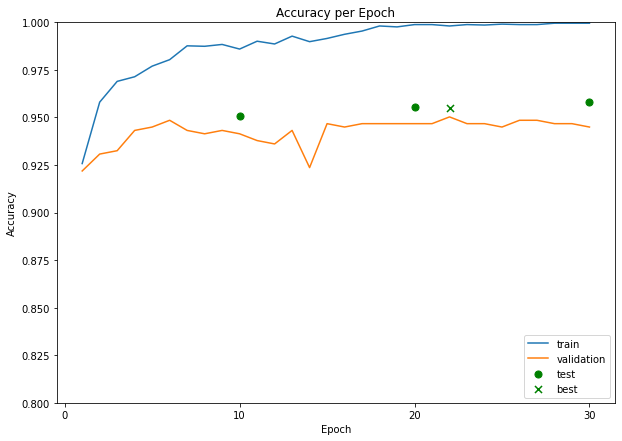

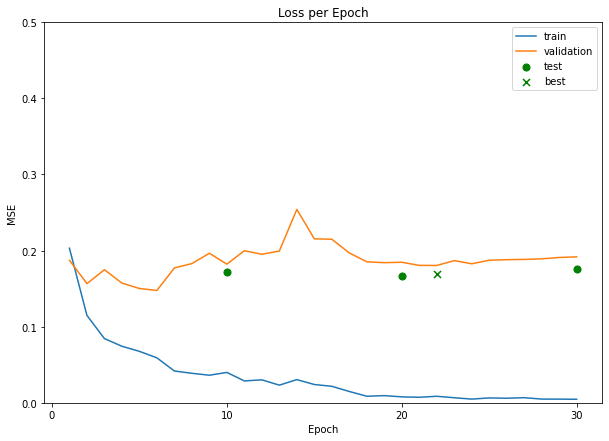

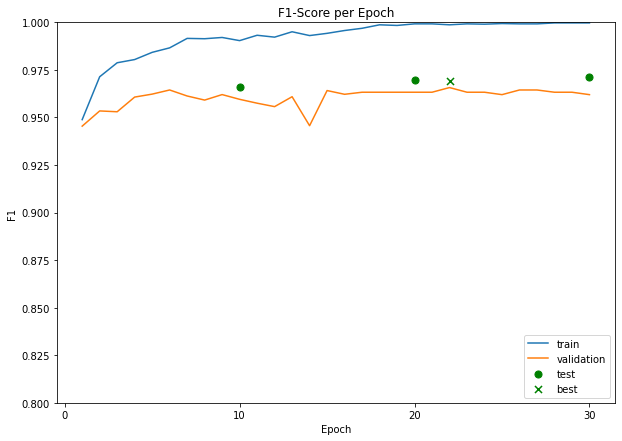

In [ ]:
num_of_x_values = len(plot_data_values[0])

# summarize history for accuracy
fig = plt.figure(figsize = (10, 7))
plt.plot(np.arange(1,num_of_x_values+1), plot_data['accuracy'])
plt.plot(np.arange(1,num_of_x_values+1), plot_data['val_accuracy'])
plt.scatter(np.arange(10,num_of_x_values+1, 10), history_test['test_accuracy'], s=50, color='green')
plt.scatter([best_epic_number], scores[1], s=50, color='green', marker='x')

plt.title('Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(0,num_of_x_values+1,10))

plt.legend(['train', 'validation', 'test', 'best'], loc='lower right')
plt.ylim([0.8,1])

plt.show()

# summarize history for loss
fig = plt.figure(figsize = (10, 7))
plt.plot(np.arange(1,num_of_x_values+1), plot_data['loss'])
plt.plot(np.arange(1,num_of_x_values+1), plot_data['val_loss'])
plt.scatter(np.arange(10,num_of_x_values+1, 10), history_test['test_loss'], s=50, color='green')
plt.scatter([best_epic_number], scores[0], s=50, color='green', marker='x')

plt.title('Loss per Epoch')
plt.ylabel('MSE')
plt.xlabel('Epoch')
#plt.xticks(np.arange(1,len(history.epoch)+1))
plt.xticks(np.arange(0,num_of_x_values+1,10))
plt.legend(['train', 'validation', 'test', 'best'], loc='upper right')
plt.ylim([0,0.5])

plt.show()


# f1
plot_data['f1'] = f1(np.array(plot_data['precision_1']),np.array(plot_data['recall_1']))
plot_data['val_f1'] = f1(np.array(plot_data['val_precision_1']),np.array(plot_data['val_recall_1']))
plot_data['test_f1'] = f1(np.array(history_test['test_precision']),np.array(history_test['test_recall']))

fig = plt.figure(figsize = (10, 7))
plt.plot(np.arange(1,num_of_x_values+1), plot_data['f1'])
plt.plot(np.arange(1,num_of_x_values+1), plot_data['val_f1'])
plt.scatter(np.arange(10,num_of_x_values+1, 10), plot_data['test_f1'], s=50, color='green')
plt.scatter([best_epic_number], f1(scores[2], scores[3]), s=50, color='green', marker='x')

plt.title('F1-Score per Epoch')
plt.ylabel('F1')
plt.xlabel('Epoch')
#plt.xticks(np.arange(1,len(history.epoch)+1))
plt.xticks(np.arange(0,num_of_x_values+1,10))
plt.legend(['train', 'validation', 'test', 'best'], loc='lower right')
plt.ylim([0.8,1.0])

plt.show()
